## Scale Testing
- In this note, we will check how the estimation results change with changes in the scale of the donor pool features.
- Adding donor pools with extremely different scales (e.g., 10x), as in the following experiment, can have a significant impact (bias) on the estimates

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

### setup & base model

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit(zeta_type="base")

In [3]:
print("ATT : ", sdid.hat_tau())

ATT :  -15.607966063072887


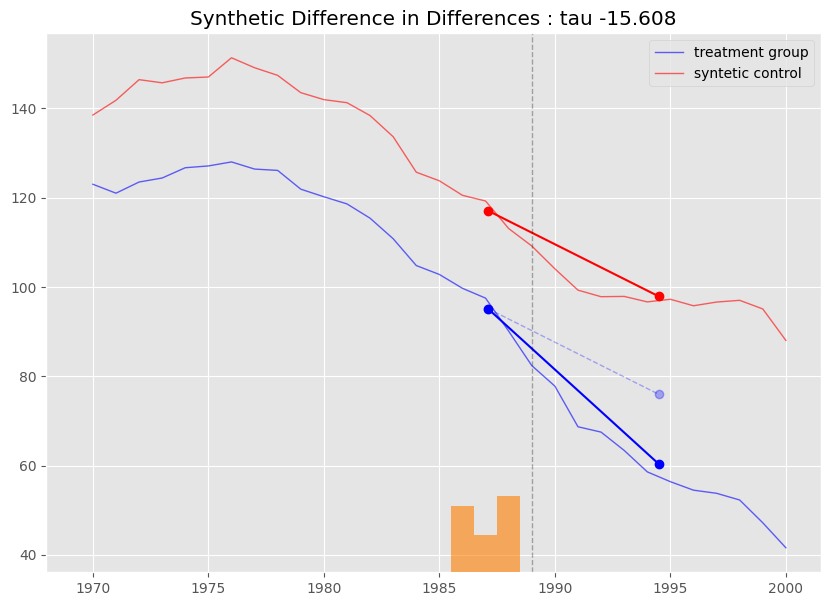

In [4]:
sdid.plot()

## unit weight (omega)
- The weight is relatively concentrated in `Nevada` & `New Hampshire`, and when plotted, it certainly seems to be moving in parallel with the treatment group (California). 

In [5]:
hat_omega_sdid, _ = sdid.estimated_params()

cm = sns.light_palette("green", as_cmap=True)
hat_omega_sdid.query("features != 'intercept' & sdid_weight >0").sort_values(
    by="sdid_weight", ascending=False
).style.background_gradient(cmap=cm)

,features,sdid_weight
19,Nevada,0.124000
20,New Hampshire,0.105000
3,Connecticut,0.078000
4,Delaware,0.070000
2,Colorado,0.057000
7,Illinois,0.053000
18,Nebraska,0.048000
17,Montana,0.045000
32,Utah,0.042000
21,New Mexico,0.041000


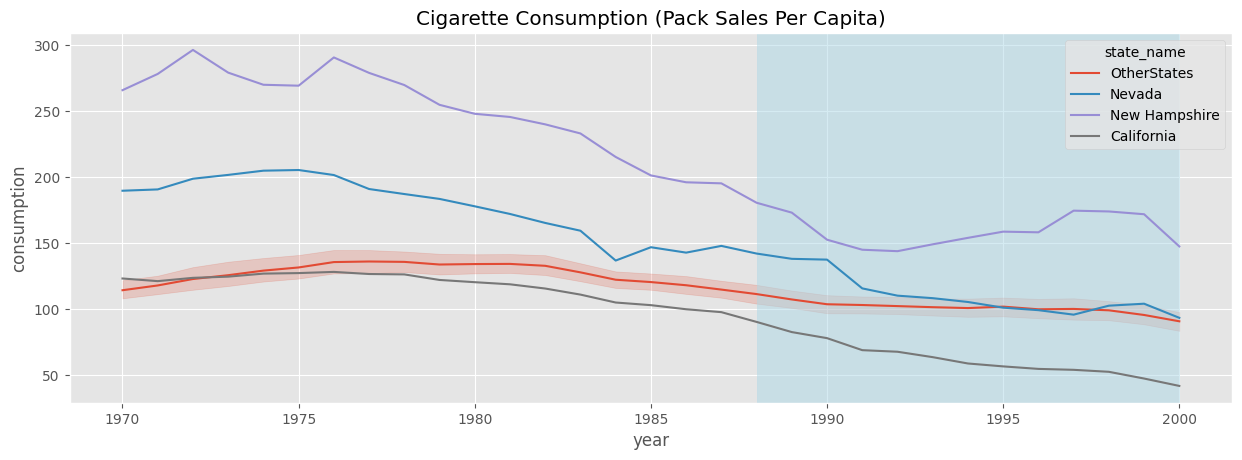

In [6]:
melt_df = pd.melt(
    df.reset_index().rename(columns={"index": "year"}),
    id_vars="year",
    value_name="consumption",
    var_name="state",
)
melt_df["state_name"] = np.where( melt_df["state"] == "California", "California", "OtherStates")
melt_df.loc[melt_df["state"] == "Nevada", "state_name"] =  "Nevada"
melt_df.loc[melt_df["state"] == "New Hampshire", "state_name"] =  "New Hampshire"

fig, ax = plt.subplots()
fig.set_figwidth(15)

sns.lineplot(x="year", y="consumption", hue="state_name", data=melt_df, ax=ax)

ax.axvspan(1988, 2000, alpha=0.5, color="lightblue")

plt.title("Cigarette Consumption (Pack Sales Per Capita)")
plt.show()

## test 1 : Nevada

In [7]:
expand_list = [0.01, 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2, 10, 50, 100]

In [8]:
nevada_omega = {}
nevada_tau = {}

for _e in tqdm(expand_list):
    if _e != 1:
        _df = df.copy()
        _df["Nevada"] = _df["Nevada"] * _e
        # re-run
        _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
        _sdid.fit(zeta_type="base")

        nevada_tau[_e] = _sdid.hat_tau()
        hat_omega_sdid, _ = _sdid.estimated_params()

    else:
        nevada_tau[_e] = sdid.hat_tau()
        hat_omega_sdid, _ = sdid.estimated_params()

    nevada_omega[_e] = hat_omega_sdid.query("features == 'Nevada'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:30<00:00,  2.76s/it]


In [9]:
nevada_tau = pd.DataFrame(nevada_tau, index = ["tau"]).T
nevada_omega = pd.DataFrame(nevada_omega, index = ["weight"]).T

In [10]:
_expand_list = [ str(_e) for _e in expand_list ]

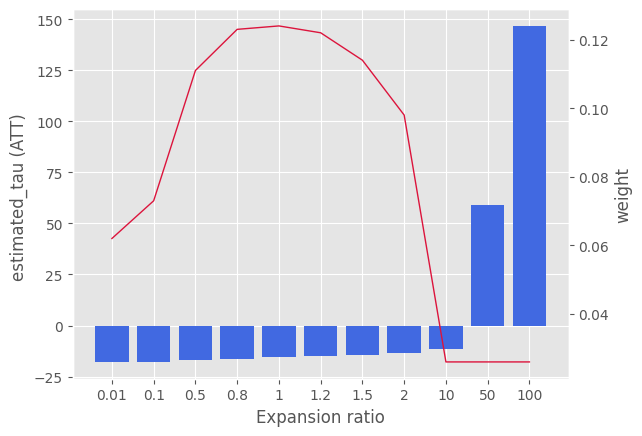

In [11]:
fig, ax1 = plt.subplots()
ax1.bar(_expand_list , nevada_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , nevada_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [12]:
nevada_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-17.827409,-17.812465,-17.121671,-16.20975,-15.607966,-15.090543,-14.462098,-13.604046,-11.526604,58.795649,146.698466


In [13]:
nevada_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.062,0.073,0.111,0.123,0.124,0.122,0.114,0.098,0.026,0.026,0.026


## test 2 : New Hampshire

In [14]:
new_hampshire_omega = {}
new_hampshire_tau = {}

for _e in tqdm(expand_list):
    if _e != 1:
        _df = df.copy()
        _df["New Hampshire"] = _df["New Hampshire"] * _e
        # re-run
        _sdid = SynthDID(_df, PRE_TEREM, POST_TEREM, TREATMENT)
        _sdid.fit(zeta_type="base")

        new_hampshire_tau[_e] = _sdid.hat_tau()
        hat_omega_sdid, _ = _sdid.estimated_params()

    else:
        new_hampshire_tau[_e] = sdid.hat_tau()
        hat_omega_sdid, _ = sdid.estimated_params()

    new_hampshire_omega[_e] = hat_omega_sdid.query("features == 'New Hampshire'")[
        "sdid_weight"
    ].values[0]

100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


In [15]:
new_hampshire_tau = pd.DataFrame(new_hampshire_tau, index = ["tau"]).T
new_hampshire_omega = pd.DataFrame(new_hampshire_omega, index = ["weight"]).T

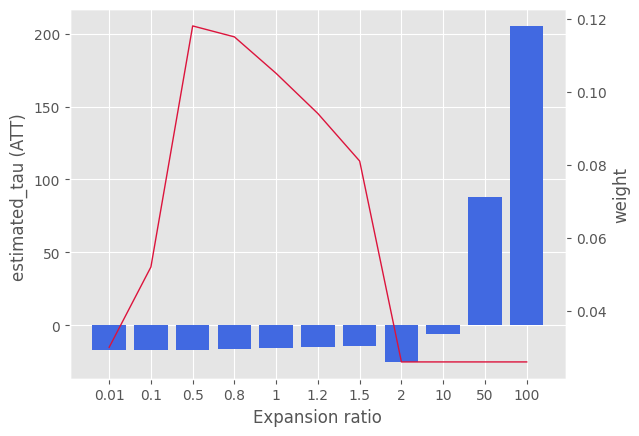

In [16]:
fig, ax1 = plt.subplots()
ax1.bar(_expand_list , new_hampshire_tau["tau"], align="center", color="royalblue", linewidth=0, label="tau")
ax1.set_ylabel('estimated_tau (ATT) ')
ax1.set_xlabel('Expansion ratio')
 
ax2 = ax1.twinx()
ax2.plot(_expand_list , new_hampshire_omega["weight"], linewidth=1, color="crimson", label="weight")
ax2.set_ylabel('weight')
ax2.grid(False)

plt.show()

In [17]:
new_hampshire_tau.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
tau,-16.659077,-17.03419,-16.992857,-16.162977,-15.607966,-15.002766,-14.303962,-24.999873,-6.205966,87.763565,205.22548


In [18]:
new_hampshire_omega.T

,0.01,0.10,0.50,0.80,1.00,1.20,1.50,2.00,10.00,50.00,100.00
weight,0.03,0.052,0.118,0.115,0.105,0.094,0.081,0.026,0.026,0.026,0.026
